# Analyze metagenome functional gene dataset
Notebook by Zach Flinkstrom - Winkler Lab - University of Washington - 07Mar2023
### Outline
1. Look at basic properties of dataset
2. Evaluate unsupervised clustering methods
3. Look at cluster-specific marker genes
4. Analyze differences in GC content

In [1]:
#import necessary packages
import anndata
import scanpy as sc
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.stats import normaltest, kruskal
import scikit_posthocs
from skbio.stats import distance
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import rand_score, adjusted_rand_score, silhouette_score, silhouette_samples
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas
from matplotlib import cm
from matplotlib.colors import ListedColormap
import random
import json

In [2]:
# Load in hdf5 file of normalized data plus metadata
filename = "data/adata_dirichlet_16_normalized.h5ad"
adata = anndata.read_h5ad(filename)
adata

AnnData object with n_obs × n_vars = 6539 × 9871
    obs: 'Domain', 'Sequencing Status', 'Study Name', 'Genome Name / Sample Name', 'Sequencing Center', 'IMG Genome ID ', 'IMG Release/Pipeline Version', 'IMG Submission ID', 'Add Date', 'Assembly Method', 'Has Coverage', 'Release Date', 'Sequencing Depth', 'Sequencing Method', 'Sequencing Quality', 'Ecosystem', 'Ecosystem Category', 'Ecosystem Subtype', 'Ecosystem Type', 'Specific Ecosystem', 'Altitude In Meters', 'Chlorophyll Concentration', 'Depth In Meters', 'Elevation In Meters', 'Geographic Location', 'Habitat', 'Isolation', 'Isolation Country', 'Latitude', 'Longhurst Code', 'Longhurst Description', 'Longitude', 'Nitrate Concentration', 'Oxygen Concentration', 'pH', 'Pressure', 'Salinity', 'Salinity Concentration', 'Sample Collection Date', 'Sample Collection Temperature', 'Subsurface In Meters', 'Genome Size   * assembled', 'Gene Count   * assembled', 'Scaffold Count   * assembled', 'Genome Bin Count   * assembled', 'CRISPR Count 

### First create consolidated source ecosystem labels
The default existing labels are multi-level and some are too specific and only have a few samples associated with them.

In [3]:
#Use 'Ecosystem Type' label if the group has more than 100 representatives
types = adata.obs['Ecosystem Type'].value_counts()[adata.obs['Ecosystem Type'].value_counts()>100].index
indices = []
for i in range(len(types)):
    indices.append(adata.obs.index[adata.obs['Ecosystem Type']==types[i]].tolist())
    
flat_list = [item for sublist in indices for item in sublist]

In [4]:
#Otherwise use the more broad 'Ecosystem' label for the more niche categories
not_indices = list(set(adata.obs.index)-set(flat_list))
adata.obs.loc[not_indices]['Ecosystem'].value_counts()

Engineered         269
Environmental      209
Host-associated     57
Name: Ecosystem, dtype: int64

In [5]:
test_dict = dict(zip(flat_list, adata.obs.loc[flat_list]['Ecosystem Type']))
test_dict.update(dict(zip(not_indices, adata.obs.loc[not_indices]['Ecosystem'])))

In [6]:
source = []
for i in adata.obs.index:
    source.append(test_dict[i])

In [7]:
#Create new metadata column called 'source'
adata.obs['source'] = source

## Create global map of sample coordinates

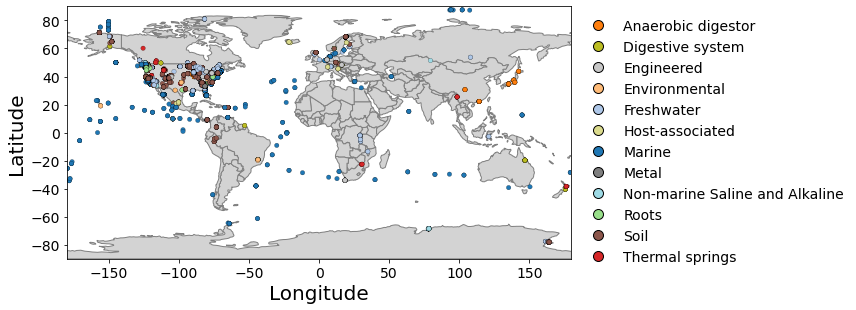

In [8]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
gdf = geopandas.GeoDataFrame(
    adata.obs.copy(), geometry=geopandas.points_from_xy(adata.obs.Longitude, adata.obs.Latitude))
tab20 = sns.color_palette("tab20", 20)
color_dict = {
'Anaerobic digestor': tab20[2],
'Digestive system': tab20[16],  
'Engineered': tab20[15],
'Environmental':tab20[3],
'Freshwater': tab20[1],
'Host-associated': tab20[17],
'Marine':tab20[0],    
'Metal': tab20[14],
'Non-marine Saline and Alkaline':tab20[19],
'Roots':tab20[5],
'Soil': tab20[10],
'Thermal springs':tab20[6]
}
color_map = [color_dict[x] for x in gdf.source]
ax = world.plot(color='lightgray', edgecolor='gray', figsize=(12,8))

cmap_new = ListedColormap([tab20[2],tab20[16],tab20[15],tab20[3],tab20[1],tab20[17],tab20[0],tab20[14],tab20[19],tab20[5],tab20[10],tab20[6]])
# We can now plot our ``GeoDataFrame``.
gdf.plot(column='source', markersize=20, legend=True, categorical=True, edgecolor='black', linewidths=0.2,
        legend_kwds=dict(loc='upper left', bbox_to_anchor=(1, 1), fontsize=14, edgecolor='white'), ax=ax, cmap=cmap_new)
for legend_handle in ax.get_legend().legendHandles:  
    legend_handle._legmarker.set_markeredgewidth(1)
    legend_handle._legmarker.set_markeredgecolor('k')
#plt.title("JGI IMG/M Metagenomes", size=28)
plt.ylabel("Latitude", size=20)
plt.xlabel("Longitude", size=20)
plt.xlim(-180,180)
plt.xticks(size=14)
plt.ylim(-90,90)
plt.yticks(size=14)
plt.tight_layout()
plt.savefig('figures/dataset_map.png', facecolor='white', dpi=300)
plt.show()

## Dataset characteristics based on metadata

In [8]:
adata #prints basic features of the AnnData object

AnnData object with n_obs × n_vars = 6539 × 9871
    obs: 'Domain', 'Sequencing Status', 'Study Name', 'Genome Name / Sample Name', 'Sequencing Center', 'IMG Genome ID ', 'IMG Release/Pipeline Version', 'IMG Submission ID', 'Add Date', 'Assembly Method', 'Has Coverage', 'Release Date', 'Sequencing Depth', 'Sequencing Method', 'Sequencing Quality', 'Ecosystem', 'Ecosystem Category', 'Ecosystem Subtype', 'Ecosystem Type', 'Specific Ecosystem', 'Altitude In Meters', 'Chlorophyll Concentration', 'Depth In Meters', 'Elevation In Meters', 'Geographic Location', 'Habitat', 'Isolation', 'Isolation Country', 'Latitude', 'Longhurst Code', 'Longhurst Description', 'Longitude', 'Nitrate Concentration', 'Oxygen Concentration', 'pH', 'Pressure', 'Salinity', 'Salinity Concentration', 'Sample Collection Date', 'Sample Collection Temperature', 'Subsurface In Meters', 'Genome Size   * assembled', 'Gene Count   * assembled', 'Scaffold Count   * assembled', 'Genome Bin Count   * assembled', 'CRISPR Count 

In [172]:
print('Genome size (terabases): ' + str(adata.obs['Genome Size   * assembled'].sum()/1e12))
print('Average genome size per sample (megabases): ' + str(adata.obs['Genome Size   * assembled'].mean()/1e6))
print('Average gene count per sample (millions): ' + str(adata.obs['Gene Count   * assembled'].mean()/1e6))
print('Average percent genes with assigned KO (%): ' + str(adata.obs['KO %   * assembled'].mean()))

Genome size (terabases): 4.850544647992
Average genome size per sample (megabases): 741.7869166526992
Average gene count per sample (millions): 1.4994591550695824
Average percent genes with assigned KO (%): 38.813789570270686


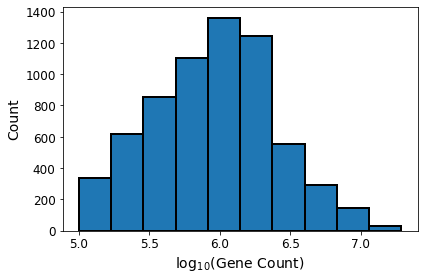

In [51]:
plt.hist(np.log10(adata.obs['Gene Count   * assembled']), bins=10, rwidth=1.0, edgecolor='black', linewidth=2.0)
plt.xlabel('log$_1$$_0$(Gene Count)', size=14)
plt.xticks(size=12)
plt.ylabel('Count', size=14)
plt.yticks(size=12)
plt.tight_layout()
plt.savefig('figures/gene_count_histogram.png', facecolor='white', dpi=300)
plt.show()

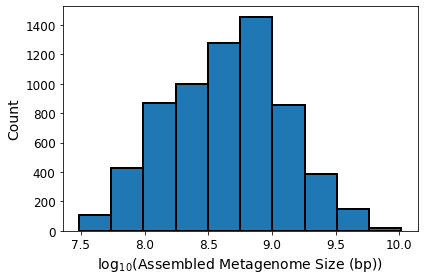

In [52]:
plt.hist(np.log10(adata.obs['Genome Size   * assembled']), bins=10, rwidth=1.0, edgecolor='black', linewidth=2.0)
plt.xlabel('log$_1$$_0$(Assembled Metagenome Size (bp))', size=14)
plt.xticks(size=12)
plt.ylabel('Count', size=14)
plt.yticks(size=12)
plt.tight_layout()
plt.savefig('figures/genome_size_histogram.png', facecolor='white', dpi=300)
plt.show()

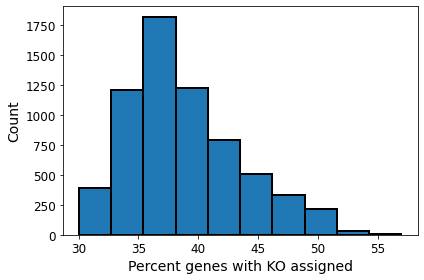

In [54]:
plt.hist(adata.obs['KO %   * assembled'], bins=10, rwidth=1.0, edgecolor='black', linewidth=2.0)
plt.xlabel('Percent genes with KO assigned', size=14)
plt.xticks(size=12)
plt.ylabel('Count', size=14)
plt.yticks(size=12)
plt.tight_layout()
plt.savefig('figures/KO_frequency_histogram.png', facecolor='white', dpi=300)
plt.show()

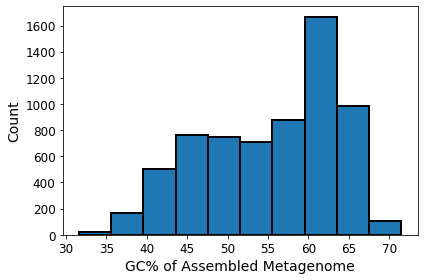

In [55]:
plt.hist(adata.obs['GC   * assembled'], bins=10, rwidth=1.0, edgecolor='black', linewidth=2.0)
plt.xlabel('GC% of Assembled Metagenome', size=14)
plt.xticks(size=12)
plt.ylabel('Count', size=14)
plt.yticks(size=12)
plt.tight_layout()
plt.savefig('figures/GC_histogram.png', facecolor='white', dpi=300)
plt.show()

## Perform bootstrapping to evaluate clustering method and optimal number of clusters

In [11]:
#get indices for the random choices then slice
def random_subset_simple(ad, size):
    #generates a random adata subset based on dictionary input of source environments and numbers
    indices = np.random.choice(list(ad.var.index), size=size, replace=True)
    return ad[:,indices]


def rand_index(cluster_list):
    #Calculate pairwise Rand scores from list of clusters
    rand_list = []
    for i in np.arange(0,len(cluster_list)-1):
        for j in np.arange(i+1, len(cluster_list)):
            rand_list.append(adjusted_rand_score(cluster_list[i], cluster_list[j]))
    return rand_list

In [28]:
#Run bootstrap resampling and hierarchical vs kmeans clustering (**WARNING:This will take a while**)
num_bootstraps = 100
num_clusters = np.arange(2,21)

hier_clusters_array = np.empty((len(num_clusters), num_bootstraps, len(adata.obs.index)))
hier_sil = np.empty((len(num_clusters), num_bootstraps))

kmeans_clusters_array = np.empty((len(num_clusters), num_bootstraps, len(adata.obs.index)))
kmeans_sil = np.empty((len(num_clusters), num_bootstraps))

for j in range(num_bootstraps):
    print("Bootstrap # " + str(j))
    subset_adata = random_subset_simple(adata, len(adata.var.index))
    dist = pdist(subset_adata.X, metric='euclidean')
    square_dist = squareform(dist)
    link = linkage(dist, method='ward', optimal_ordering=False)
    for i, k in enumerate(num_clusters):
        clusters = fcluster(link, t=k, criterion='maxclust')
        hier_clusters_array[i,j] = clusters
        hier_sil[i,j] = silhouette_score(square_dist, clusters, metric='precomputed')
        
        kmeans = KMeans(n_clusters=k, random_state=0).fit(subset_adata.X)
        kmeans_clusters_array[i,j] = kmeans.labels_
        kmeans_sil[i,j] = silhouette_score(square_dist, kmeans.labels_, metric='precomputed')

Bootstrap # 0
Bootstrap # 1
Bootstrap # 2
Bootstrap # 3
Bootstrap # 4
Bootstrap # 5
Bootstrap # 6
Bootstrap # 7
Bootstrap # 8
Bootstrap # 9
Bootstrap # 10
Bootstrap # 11
Bootstrap # 12
Bootstrap # 13
Bootstrap # 14
Bootstrap # 15
Bootstrap # 16
Bootstrap # 17
Bootstrap # 18
Bootstrap # 19
Bootstrap # 20
Bootstrap # 21
Bootstrap # 22
Bootstrap # 23
Bootstrap # 24
Bootstrap # 25
Bootstrap # 26
Bootstrap # 27
Bootstrap # 28
Bootstrap # 29
Bootstrap # 30
Bootstrap # 31
Bootstrap # 32
Bootstrap # 33
Bootstrap # 34
Bootstrap # 35
Bootstrap # 36
Bootstrap # 37
Bootstrap # 38
Bootstrap # 39
Bootstrap # 40
Bootstrap # 41
Bootstrap # 42
Bootstrap # 43
Bootstrap # 44
Bootstrap # 45
Bootstrap # 46
Bootstrap # 47
Bootstrap # 48
Bootstrap # 49
Bootstrap # 50
Bootstrap # 51
Bootstrap # 52
Bootstrap # 53
Bootstrap # 54
Bootstrap # 55
Bootstrap # 56
Bootstrap # 57
Bootstrap # 58
Bootstrap # 59
Bootstrap # 60
Bootstrap # 61
Bootstrap # 62
Bootstrap # 63
Bootstrap # 64
Bootstrap # 65
Bootstrap # 66
Boots

In [29]:
#Compute pairwise adjusted Rand scores for the two cluster lists
hier_rand_list = []
for i in hier_clusters_array:
    hier_rand_list.append(rand_index(i))
    
kmeans_rand_list = []
for i in kmeans_clusters_array:
    kmeans_rand_list.append(rand_index(i))

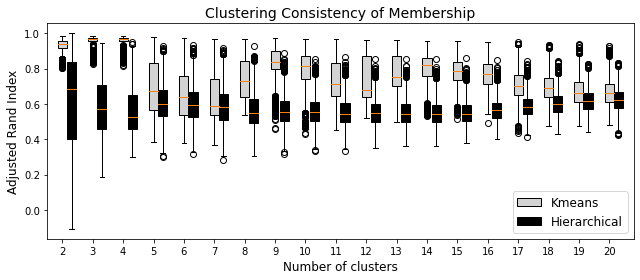

In [30]:
#Plot Rand index results
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
# rectangular box plot
bp1 = ax1.boxplot(kmeans_rand_list,
                     widths=0.3,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     positions=num_clusters,
                    boxprops=dict(facecolor='lightgray', color='black'),
                    flierprops=dict(color='lightgray', markeredgecolor='black'))  # will be used to label x-ticks
ax1.set_title('Clustering Consistency of Membership', size=14)

# notch shape box plot
bp2 = ax1.boxplot(hier_rand_list,
                     widths=0.3,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     positions=num_clusters+0.3,
                    boxprops=dict(facecolor='black', color='black'))  # will be used to label x-ticks

ax1.set_xlabel('Number of clusters', size=12)
ax1.set_ylabel('Adjusted Rand Index', size=12)
ax1.set_xticks(num_clusters)
ax1.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Kmeans', 'Hierarchical'], loc='lower right',fontsize=12)
plt.tight_layout()
plt.savefig('figures/Rand_index_comparison.png',dpi=300)

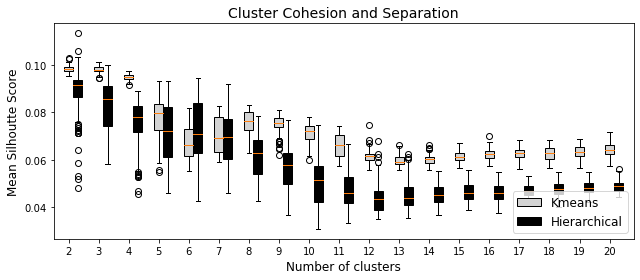

In [31]:
#Plot Silhouette score results
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
# rectangular box plot
bp1 = ax1.boxplot(np.transpose(kmeans_sil),
                     widths=0.3,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     positions=num_clusters,
                    boxprops=dict(facecolor='lightgray', color='black'),
                    flierprops=dict(color='lightgray', markeredgecolor='black'))  # will be used to label x-ticks
ax1.set_title('Cluster Cohesion and Separation', size=14)

# notch shape box plot
bp2 = ax1.boxplot(np.transpose(hier_sil),
                     widths=0.3,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     positions=num_clusters+0.3,
                    boxprops=dict(facecolor='black', color='black'))  # will be used to label x-ticks

ax1.set_xlabel('Number of clusters', size=12)
ax1.set_ylabel('Mean Silhoutte Score', size=12)
ax1.set_xticks(num_clusters)
ax1.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Kmeans', 'Hierarchical'], loc='lower right',fontsize=12)
plt.tight_layout()
plt.savefig('figures/Silhouette_comparison.png',dpi=300)

## Perform Kmeans clustering

In [9]:
#First randomly split adata 50/50 into train and test sets
train_index = random.sample(range(adata.n_obs), int(adata.n_obs/2))
test_index = list(set(range(adata.n_obs))-set(train_index))
train_adata = adata[train_index]
test_adata = adata[test_index]

In [10]:
#Perform Kmeans clustering using 3 clusters based on previous analysis
kmeans = KMeans(n_clusters=3, random_state=10).fit(train_adata.X)

In [11]:
#Predict labels of all data
labels = kmeans.predict(adata.X)

In [12]:
#Adjust cluster numbers to correspond to number of samples ie cluster 0 has most, cluster 2 has least members
cluster_mapper = {}
for i,j in enumerate(Counter(labels).most_common()):
    cluster_mapper[j[0]] = i+1
cluster_mapper

{1: 1, 0: 2, 2: 3}

In [13]:
#create kmeans cluster attribute in the adata.obs table
adata.obs['kmeans'] = ['Cluster '+str(cluster_mapper[i]) for i in labels]

In [14]:
#export metadata table with kmeans labels added
adata.obs.to_csv('output/adata_obs_metadata.csv')

In [37]:
#Compute pairwise distances and average silhouette score for the clustering
dist = pdist(adata.X, metric='euclidean')
square_dist = squareform(dist)
print("Average Silhouette Score:")
print(silhouette_score(square_dist, labels, metric='precomputed'))

Average Silhouette Score:
0.09806128707303216


In [38]:
#Also compute and plot UMAP
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=5)
sc.tl.umap(adata, n_components=2)

... storing 'source' as categorical
... storing 'kmeans' as categorical


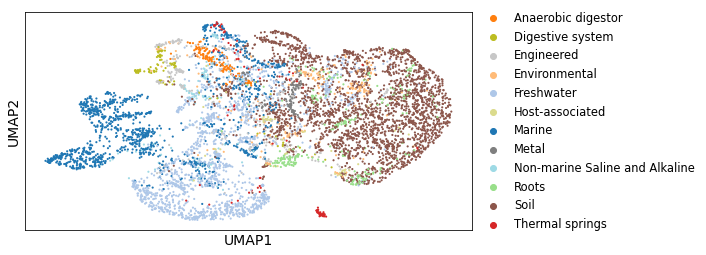

In [41]:
#Plot UMAP with Source environment colors
fig, ax = plt.subplots(1,1, figsize=(8, 4))
ax.set_xlabel('UMAP1', size=14)
ax.set_ylabel('UMAP2', size=14)
sc.pl.umap(adata, color='source', palette=color_dict, legend_fontsize=11.5, title='', ax=ax)
fig.tight_layout()
fig.savefig('figures/umap_source.png', facecolor='white', dpi=300)

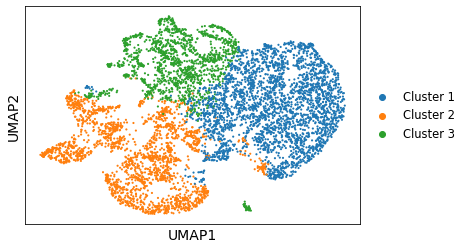

In [42]:
#Plot UMAP with Kmeans colors
fig, ax = plt.subplots(1,1, figsize=(6, 4))
ax.set_xlabel('UMAP1', size=14)
ax.set_ylabel('UMAP2', size=14)
sc.pl.umap(adata, color='kmeans', legend_fontsize=11.5, title='', ax=ax)
fig.tight_layout()
fig.savefig('figures/umap_kmeans.png', facecolor='white', dpi=300)

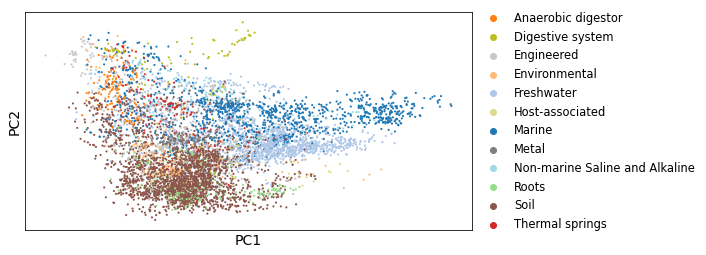

In [43]:
#Plot PCA with source environment colors
fig, ax = plt.subplots(1,1, figsize=(8, 4))
ax.set_xlabel('PC1', size=14)
ax.set_ylabel('PC2', size=14)
sc.pl.pca(adata, color='source', palette=color_dict, legend_fontsize=11.5, title='', ax=ax)
fig.tight_layout()
fig.savefig('figures/pca_source.png', facecolor='white', dpi=300)

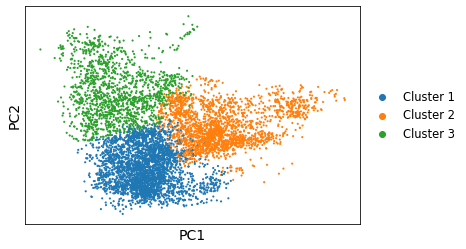

In [44]:
#Plot PCA with Kmeans colors
fig, ax = plt.subplots(1,1, figsize=(6, 4))
ax.set_xlabel('PC1', size=14)
ax.set_ylabel('PC2', size=14)
sc.pl.pca(adata, color='kmeans', legend_fontsize=11.5, title='', ax=ax)
fig.tight_layout()
fig.savefig('figures/pca_kmeans.png', facecolor='white', dpi=300)

## Compute ANOSIM statistics on groupings

In [543]:
skbio_mat = DistanceMatrix(square_dist)

In [551]:
distance.anosim(skbio_mat, adata.obs['kmeans'], permutations=30)

method name                  ANOSIM
test statistic name               R
sample size                    6539
number of groups                  3
test statistic             0.556716
p-value                   0.0322581
number of permutations           30
Name: ANOSIM results, dtype: object

In [552]:
distance.anosim(skbio_mat, adata.obs['source'], permutations=30)

method name                  ANOSIM
test statistic name               R
sample size                    6539
number of groups                 12
test statistic              0.50886
p-value                   0.0322581
number of permutations           30
Name: ANOSIM results, dtype: object

In [553]:
distance.anosim(skbio_mat, adata.obs['Pipeline'], permutations=30)

method name                  ANOSIM
test statistic name               R
sample size                    6539
number of groups                  2
test statistic           -0.0101625
p-value                           1
number of permutations           30
Name: ANOSIM results, dtype: object

## Look at pairwise distances within source environments

In [45]:
source_dist_dict = {}
for env in set(adata.obs['source']):
    print(env)
    source_dist_dict[env] = square_dist[:,adata.obs['source']==env][adata.obs['source']==env,:].flatten()

Thermal springs
Digestive system
Freshwater
Marine
Roots
Host-associated
Non-marine Saline and Alkaline
Environmental
Engineered
Anaerobic digestor
Soil
Metal


In [153]:
medians = [np.median(source_dist_dict[i]) for i in source_dist_dict]
keys = list(source_dist_dict.keys())
df = pd.DataFrame([keys,medians]).T.sort_values(by=1)
df

,0,1
6,Metal,279.907
5,Anaerobic digestor,311.693
2,Soil,362.211
10,Environmental,389.718
0,Roots,391.522
1,Freshwater,408.343
11,Non-marine Saline and Alkaline,429.542
3,Marine,430.122
4,Thermal springs,460.932
9,Digestive system,470.055


Text(0.5, 0, 'Source Environment')

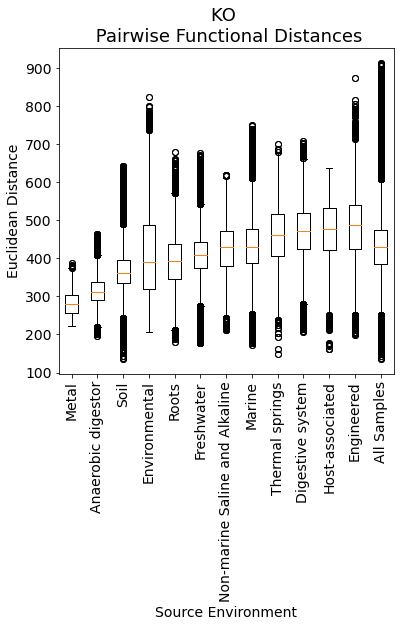

In [154]:
plt.close()
fig, ax = plt.subplots(1,1, figsize=(6,6))
plt.boxplot([source_dist_dict[i][source_dist_dict[i]>0] for i in df[0]]+[square_dist.flatten()[square_dist.flatten()>0]])
plt.xticks(np.arange(1,len(source_dist_dict)+2),[i for i in df[0]]+["All Samples"],rotation=90,size=14)
plt.yticks(size=14)
plt.title("KO \n Pairwise Functional Distances", size=18)
plt.ylabel("Euclidean Distance", size=14)
plt.xlabel("Source Environment", size=14)

## Compare clustering by Kmeans vs ecosystem label

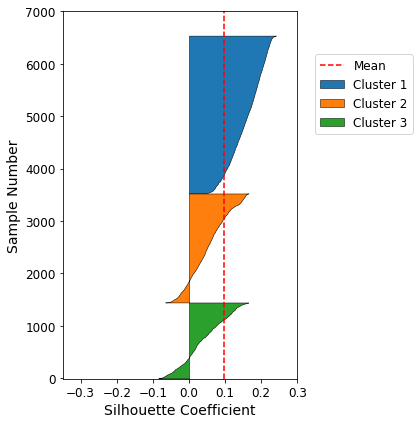

In [46]:
kmeans_sil_samples = silhouette_samples(square_dist, adata.obs['kmeans'], metric='precomputed')
plt.figure(figsize=(6,6))
y_start = len(adata.obs.kmeans)
for i in ['Cluster 1','Cluster 2','Cluster 3']:
    zero_cluster = kmeans_sil_samples[adata.obs['kmeans']==i]
    y_end = y_start - len(zero_cluster)
    plt.fill_betweenx(np.arange(y_end, y_start), np.sort(zero_cluster), edgecolor='black', linewidth=0.5, label=i)
    #plt.text(0.3, (y_end+y_start)/2, '- '+str(i), size=14)
    y_start = y_end# + 50
plt.axvline(x=np.mean(kmeans_sil_samples), color="red", linestyle="--", label='Mean')
#plt.title("Kmeans Clustering", size=20)
plt.xlabel("Silhouette Coefficient", size=14)
plt.xlim([-0.35,0.3])
plt.ylim([-10,7000])
plt.ylabel('Sample Number', size=14)
plt.yticks(size=12)
plt.xticks(size=12)
plt.legend(bbox_to_anchor=(1.05,0.9), loc='upper left', fontsize=12)
plt.tight_layout()
plt.savefig('figures/kmeans_silhouette_scores.png', facecolor='white', dpi=300)
plt.show()

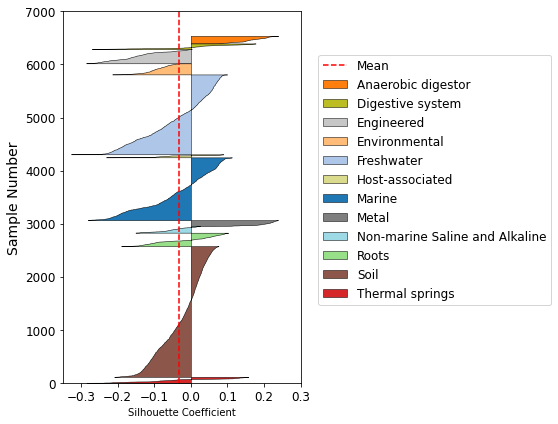

In [238]:
source_sil_samples = silhouette_samples(square_dist, adata.obs['source'], metric='precomputed')
plt.figure(figsize=(8,6))
y_start = len(adata.obs.source)
for i in np.sort(list(set(adata.obs.source))):
    zero_cluster = source_sil_samples[adata.obs['source']==i]
    y_end = y_start - len(zero_cluster)
    plt.fill_betweenx(np.arange(y_end, y_start), np.sort(zero_cluster), color=color_dict[i], edgecolor='black', linewidth=0.5, label=i)
    #plt.text(.30, (y_start+y_end)/2-10, '- '+i, size=11)
    y_start = y_end
plt.axvline(x=np.mean(source_sil_samples), color="red", linestyle="--", label='Mean')
#plt.title("Ecosystem Label Clustering", size=20)
plt.xlabel("Silhouette Coefficient")
plt.xlim([-0.35,0.3])
plt.ylim([0,7000])
plt.ylabel('Sample Number', size=14)
plt.yticks(size=12)
plt.xticks(size=12)
plt.legend(bbox_to_anchor=(1.05,0.9), loc='upper left', fontsize=12)
plt.tight_layout()
plt.savefig('figures/source_env_silhouette_scores.png', facecolor='white', dpi=300)

plt.show()

## Cluster composition by source environment

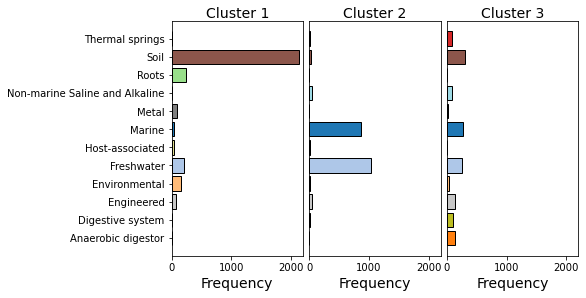

In [48]:
color_dict = {
'Anaerobic digestor': tab20[2],
'Digestive system': tab20[16],  
'Engineered': tab20[15],
'Environmental':tab20[3],
'Freshwater': tab20[1],
'Host-associated': tab20[17],
'Marine':tab20[0],    
'Metal': tab20[14],
'Non-marine Saline and Alkaline':tab20[19],
'Roots':tab20[5],
'Soil': tab20[10],
'Thermal springs':tab20[6]
}

fig, ax = plt.subplots(1,3, figsize=(8,4))
for i, j in enumerate(['Cluster 1','Cluster 2','Cluster 3']):
    data = adata.obs[adata.obs.kmeans==j].source
    colors = [color_dict[i] for i in data.value_counts(normalize=True, sort=False).keys()]
    ax[i].barh(data.value_counts(normalize=True, sort=False).keys(),data.value_counts(normalize=False, sort=False), edgecolor='black', color=colors)
    ax[i].set_title(j, size=14, pad=2.)
    ax[i].set_xlabel('Frequency', size=14)
    ax[i].set_xlim([0, 2200])

ax[1].set_yticks([])
ax[2].set_yticks([])
#plt.xticks(rotation=90, size=12)
plt.yticks(fontsize=14)
plt.tight_layout(pad=0.2)
plt.savefig('figures/cluster_composition_horizontal.png', facecolor='white', dpi=300)
plt.show()

In [52]:
#Crosstab of source environment and cluster
crosstab = pd.crosstab(index=adata.obs.source, columns=adata.obs.kmeans)
crosstab

kmeans,Cluster 1,Cluster 2,Cluster 3
source,,,
Anaerobic digestor,0,0,142
Digestive system,9,4,93
Engineered,78,50,141
Environmental,156,16,37
Freshwater,215,1034,257
Host-associated,36,19,2
Marine,46,873,265
Metal,85,0,25
Non-marine Saline and Alkaline,0,45,81


In [154]:
#Percentages of samples in each cluster
crosstab/crosstab.sum(axis=0)*100

kmeans,Cluster 1,Cluster 2,Cluster 3
source,,,
Anaerobic digestor,0.000000,0.000000,9.813407
Digestive system,0.298805,0.192308,6.427091
Engineered,2.589641,2.403846,9.744299
Environmental,5.179283,0.769231,2.557015
Freshwater,7.138114,49.711538,17.760885
Host-associated,1.195219,0.913462,0.138217
Marine,1.527224,41.971154,18.313753
Metal,2.822045,0.000000,1.727713
Non-marine Saline and Alkaline,0.000000,2.163462,5.597789


In [151]:
#Percentages of clusters for each source environment.
crosstab.div(crosstab.sum(axis=1), axis=0)*100

kmeans,Cluster 1,Cluster 2,Cluster 3
source,,,
Anaerobic digestor,0.000000,0.000000,100.000000
Digestive system,8.490566,3.773585,87.735849
Engineered,28.996283,18.587361,52.416357
Environmental,74.641148,7.655502,17.703349
Freshwater,14.276228,68.658699,17.065073
Host-associated,63.157895,33.333333,3.508772
Marine,3.885135,73.733108,22.381757
Metal,77.272727,0.000000,22.727273
Non-marine Saline and Alkaline,0.000000,35.714286,64.285714


In [50]:
#Chi square test
from scipy.stats import chi2_contingency, chisquare
chi2_contingency(pd.crosstab(index=adata.obs.source, columns=adata.obs.kmeans))

(5495.3835468683155,
 0.0,
 22,
 array([[  65.40816639,   45.16898608,   31.42284753],
        [  48.82581434,   33.71769384,   23.45649182],
        [ 123.90701942,   85.5666004 ,   59.52638018],
        [  96.26976602,   66.48111332,   46.24912066],
        [ 693.69506041,  479.04572565,  333.25921395],
        [  26.25539073,   18.13121272,   12.61339654],
        [ 545.37513381,  376.62027833,  262.00458786],
        [  50.6682979 ,   34.99005964,   24.34164245],
        [  58.03823215,   40.07952286,   27.88224499],
        [ 116.53708518,   80.47713718,   55.98577764],
        [1134.96987307,  783.77733598,  545.25279095],
        [  52.05016058,   35.944334  ,   25.00550543]]))

## Identify and analyze cluster-specific marker genes

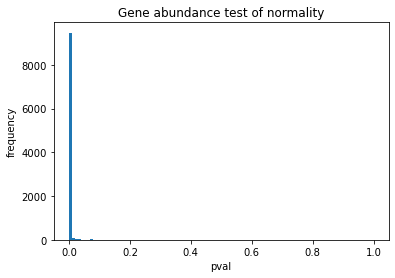

In [60]:
#First test gene abundance values for normality
normaltest_res = normaltest(adata.X, axis=0)
plt.hist(normaltest_res[1], bins=100)
plt.ylabel('frequency')
plt.xlabel('pval')
plt.title('Gene abundance test of normality')
plt.show()

* center-log ratio normalized gene abundances are not normally distributed, so we will need to use non-parametric tests for differential abundance

In [61]:
#Run Kruskal-Wallis test on gene abundances across clusters
kruskal_res = []
for i in range(len(adata.var.index)):
    kruskal_res.append(kruskal(adata.X[adata.obs.kmeans=='Cluster 1',i], adata.X[adata.obs.kmeans=='Cluster 2',i], adata.X[adata.obs.kmeans=='Cluster 3',i]).pvalue)

In [62]:
#apply kruskal results to the adata genes tab
adata.var['kruskal_pval'] = kruskal_res

In [63]:
#Perform Dunn's posthoc test for pairwise cluster comparisons
dunns = []
for i in range(len(adata.var.index)):
    #gives 1D version of result table in order [cluster0:cluster1, cluster0:cluster2, cluster1:cluster2]
    dunns.append(list(scikit_posthocs.posthoc_dunn([adata.X[adata.obs.kmeans=='Cluster 1',i], adata.X[adata.obs.kmeans=='Cluster 2',i], adata.X[adata.obs.kmeans=='Cluster 3',i]]).melt().loc[[1,2,5]].value))

In [64]:
#Add Dunn's test results to the adata.var dataframe
adata.var['dunns_1-2'] = np.array(dunns)[:, 0]
adata.var['dunns_1-3'] = np.array(dunns)[:, 1]
adata.var['dunns_2-3'] = np.array(dunns)[:, 2]

In [65]:
#calculate pairwise log2 fold changes for the genes ad add to adata.var dataframe
adata.var['fc_1-2'] = np.median(adata.X[adata.obs.kmeans=='Cluster 1',:],axis=0)-np.median(adata.X[adata.obs.kmeans=='Cluster 2',:],axis=0)
adata.var['fc_1-3'] = np.median(adata.X[adata.obs.kmeans=='Cluster 1',:],axis=0)-np.median(adata.X[adata.obs.kmeans=='Cluster 3',:],axis=0)
adata.var['fc_2-3'] = np.median(adata.X[adata.obs.kmeans=='Cluster 2',:],axis=0)-np.median(adata.X[adata.obs.kmeans=='Cluster 3',:],axis=0)

In [66]:
#Simplify pairwise fold changes per cluster by only looking at the minimum fold change for the comparisons
adata.var['minfc_1'] = np.min([adata.var['fc_1-2'],adata.var['fc_1-3']], axis=0)
adata.var['minfc_2'] = np.min([-adata.var['fc_1-2'],adata.var['fc_2-3']], axis=0)
adata.var['minfc_3'] = np.min([-adata.var['fc_1-3'],-adata.var['fc_2-3']], axis=0)

In [67]:
#Simplify pairwise p-vals per cluster by only looking at the max p-value for the comparisons
adata.var['maxp_1'] = np.max([adata.var['dunns_1-2'],adata.var['dunns_1-3']], axis=0)
adata.var['maxp_2'] = np.max([adata.var['dunns_1-2'],adata.var['dunns_2-3']], axis=0)
adata.var['maxp_3'] = np.max([adata.var['dunns_1-3'],adata.var['dunns_2-3']], axis=0)

## Establish fold-change cutoff/pvalue based on permutation testing
Randomly group samples into 3 groups like k-means sizes and compute fold changes.

In [93]:
random_fcs = np.empty(0)
for i in range(100):
    output = list(adata.obs.kmeans)
    random.shuffle(output)
    zeros = [i=='Cluster 1' for i in output]
    ones = [i=='Cluster 2' for i in output]
    twos = [i=='Cluster 3' for i in output]
    perm_fcs = np.empty(0)
    perm_fcs = np.concatenate([perm_fcs, np.median(adata.X[zeros,:],axis=0)-np.median(adata.X[ones,:],axis=0)])
    perm_fcs = np.concatenate([perm_fcs, np.median(adata.X[zeros,:],axis=0)-np.median(adata.X[twos,:],axis=0)])
    perm_fcs = np.concatenate([perm_fcs, np.median(adata.X[ones,:],axis=0)-np.median(adata.X[twos,:],axis=0)])
    random_fcs = np.append(random_fcs, perm_fcs)

In [103]:
# Probability of random fold change greater than 2 or less than -2
np.sum(np.abs(random_fcs)>2.)/len(random_fcs)

3.3768952824772906e-07

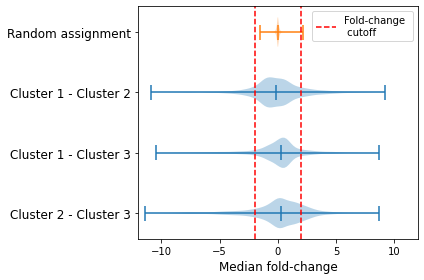

In [94]:
#Plot fold-change distributions
plt.violinplot([adata.var['fc_1-2'], adata.var['fc_1-3'], adata.var['fc_2-3']], positions=[3,2,1], showmedians=True, vert=False)
plt.violinplot([random_fcs], positions=[4], showmedians=True, vert=False)

plt.axline((2,1),(2,2), color='red', linestyle='--', label='Fold-change \n cutoff')
plt.axline((-2,1),(-2,2), color='red', linestyle='--')
plt.xlabel('Median log$_2$(fold-change)', size=12)
plt.yticks([4,3,2,1],['Random assignment','Cluster 1 - Cluster 2', 'Cluster 1 - Cluster 3', 'Cluster 2 - Cluster 3'], size=12)
plt.xlim([-12,12])
plt.legend()
plt.tight_layout()
plt.savefig('figures/fold-change_violin.png', facecolor='white', dpi=300)

In [144]:
for j in range(100):
    print(j)
    random.shuffle(output)
    zeros = [i=='Cluster 1' for i in output]
    ones = [i=='Cluster 2' for i in output]
    twos = [i=='Cluster 3' for i in output]
    #Perform Dunn's posthoc test for pairwise cluster comparisons
    random_dunns = []
    for i in range(len(adata.var.index)):
        #gives 1D version of result table in order [cluster0:cluster1, cluster0:cluster2, cluster1:cluster2]
        random_dunns.append(list(scikit_posthocs.posthoc_dunn([adata.X[zeros,i], adata.X[ones,i], adata.X[twos,i]]).melt().loc[[1,2,5]].value))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [145]:
#Bonferroni cutoff p-value
cutoff_p = 0.001/len(adata.var.index)
cutoff_p

1.0130685847431871e-07

In [146]:
# Proportion of random p-values less than Bonferroni cutoff p-value
np.sum(np.abs(random_dunns)<cutoff_p)/len(random_dunns)

0.0

In [147]:
1/len(random_dunns)

0.00010130685847431871

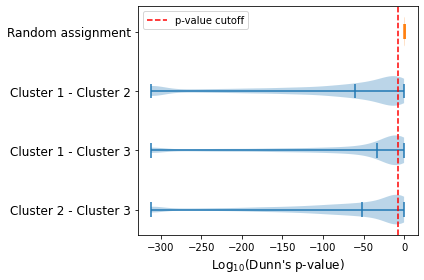

In [148]:
#Plot Dunn's p-value distributions
flat_list = [item for sublist in random_dunns for item in sublist]
plt.violinplot([np.log10(adata.var['dunns_1-2']+1e-312), np.log10(adata.var['dunns_1-3']+1e-312), np.log10(adata.var['dunns_2-3']+1e-312)], positions=[3,2,1], showmedians=True, vert=False)
plt.violinplot([flat_list], positions=[4], showmedians=True, vert=False)

plt.axline((np.log10(cutoff_p),1),(np.log10(cutoff_p),2), color='red', linestyle='--', label='p-value cutoff')
plt.xlabel('Log$_1$$_0$(Dunn\'s p-value)', size=12)
plt.yticks([4,3,2,1],['Random assignment','Cluster 1 - Cluster 2', 'Cluster 1 - Cluster 3', 'Cluster 2 - Cluster 3'], size=12)
plt.legend()
plt.tight_layout()
plt.savefig('figures/dunns_pval_violin.png', facecolor='white', dpi=300)

In [80]:
#export gene info dataframe containing p-values and fold-changes
adata.var.to_csv('output/adata_var.csv')

## KEGG Database Information for Marker Genes

In [121]:
def get_paths(source, name="", target = None):
    '''Returns path in nested json of the target value/KO gene
    code modified from Stack Exchange: 
    https://stackoverflow.com/questions/73168515/find-nested-json-path-with-key-using-python'''
    if isinstance(source, dict):
        for source_key, source_value in source.items():
            source_name = source['name']
            tmp_name = f"{name}|{source_name}" if name else source_name
            if source_value[:6] == target:
                yield tmp_name
            else:
                yield from get_paths(source_value, tmp_name, target)
    elif isinstance(source, (list, tuple, set, frozenset)):
        for value in source:
            yield from get_paths(value, name, target)

In [122]:
#Import json with KEGG KO to BRITE associations
brite_file = 'data/BRITE_json_ko00001.json'
with open(brite_file, "r") as f:
    data = json.loads(f.read())

In [123]:
#Process Cluster 1 marker genes
marker_genes_1 = adata.var[(adata.var.minfc_1 > 2.0)&(adata.var.maxp_1 < cutoff_p)]
brites_1 = []
for i in marker_genes_1.index:
    for j in get_paths(data, target=str(i[3:])):
        brites_1.append(j.split('|')) 
df1 = pd.DataFrame(brites_1)
df1['cluster'] = np.repeat('Cluster_1', len(df1.index))

#Process Cluster 2 marker genes
marker_genes_2 = adata.var[(adata.var.minfc_2 > 2.0)&(adata.var.maxp_2 < cutoff_p)]
brites_2 = []
for i in marker_genes_2.index:
    for j in get_paths(data, target=str(i[3:])):
        brites_2.append(j.split('|'))       
df2 = pd.DataFrame(brites_2)
df2['cluster'] = np.repeat('Cluster_2', len(df2.index))

#Process Cluster 3 marker genes
marker_genes_3 = adata.var[(adata.var.minfc_3 > 2.0)&(adata.var.maxp_3 < cutoff_p)]
brites_3 = []
for i in marker_genes_3.index:
    for j in get_paths(data, target=str(i[3:])):
        brites_3.append(j.split('|'))      
df3 = pd.DataFrame(brites_3)
df3['cluster'] = np.repeat('Cluster_3', len(df3.index))

#Combine marker genes from each cluster
combined = df1.append(df2.append(df3))
combined

In [177]:
print("Cluster 1 marker gene #: " + str(len(marker_genes_1.index)))
print("Cluster 2 marker gene #: " + str(len(marker_genes_2.index)))
print("Cluster 3 marker gene #: " + str(len(marker_genes_3.index)))

Cluster 1 marker gene #: 684
Cluster 2 marker gene #: 945
Cluster 3 marker gene #: 917


In [265]:
#Output marker gene category information to csv
combined.to_csv('output/marker_gene_categories.csv')

[55, 29, 23, 12, 44, 6, 23, 36, 77, 28, 112]
[45, 106, 24, 18, 29, 6, 20, 35, 17, 4, 13]
[127, 131, 9, 25, 58, 13, 11, 42, 6, 5, 23]


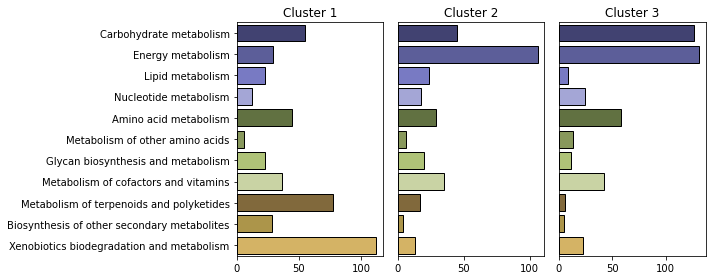

In [178]:
# Plot marker gene count per each KEGG metabolism category
fig, ax = plt.subplots(1, 3, figsize=(10,4))
cats = np.sort(list(set(combined[(combined[1]=='09100 Metabolism')][2])))
labels = [i[6:] for i in cats]
for i in [1,2,3]:
    tmp = combined[(combined[1]=='09100 Metabolism')&(combined.cluster=='Cluster_'+str(i))][2].value_counts()
    vals = [tmp[j] if j in tmp.index else 0. for j in cats]
    sns.barplot(y=labels, x=vals, ax=ax[i-1], palette='tab20b', edgecolor='black')
    ax[i-1].set_title('Cluster '+str(i))
    ax[i-1].set_ylabel('')
    #ax[i-1].set_xlim([0,100])
    print(vals)
    if i != 1:
        ax[i-1].set_yticks([])  
plt.tight_layout()
plt.savefig('figures/09100_Metabolism_bar.png', dpi=300, facecolor='white')

['Glycolysis / Gluconeogenesis ', 'Citrate cycle (TCA cycle) ', 'Pentose phosphate pathway ', 'Pentose and glucuronate interconversions ', 'Fructose and mannose metabolism ', 'Galactose metabolism ', 'Ascorbate and aldarate metabolism ', 'Starch and sucrose metabolism ', 'Amino sugar and nucleotide sugar metabolism ', 'Inositol phosphate metabolism ', 'Pyruvate metabolism ', 'Glyoxylate and dicarboxylate metabolism ', 'Propanoate metabolism ', 'Butanoate metabolism ', 'C5-Branched dibasic acid metabolism ']
[3, 1, 3, 5, 3, 3, 4, 6, 1, 2, 6, 5, 2, 10, 1]
['Glycolysis / Gluconeogenesis ', 'Citrate cycle (TCA cycle) ', 'Pentose phosphate pathway ', 'Pentose and glucuronate interconversions ', 'Fructose and mannose metabolism ', 'Galactose metabolism ', 'Ascorbate and aldarate metabolism ', 'Starch and sucrose metabolism ', 'Amino sugar and nucleotide sugar metabolism ', 'Inositol phosphate metabolism ', 'Pyruvate metabolism ', 'Glyoxylate and dicarboxylate metabolism ', 'Propanoate metabo

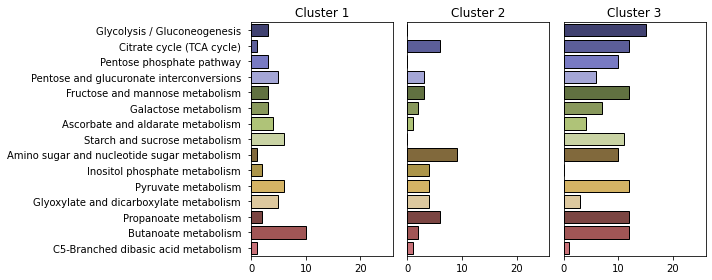

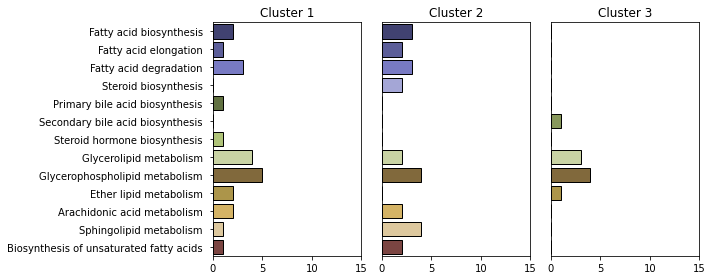

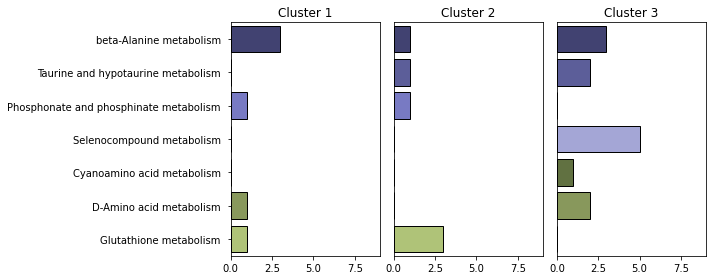

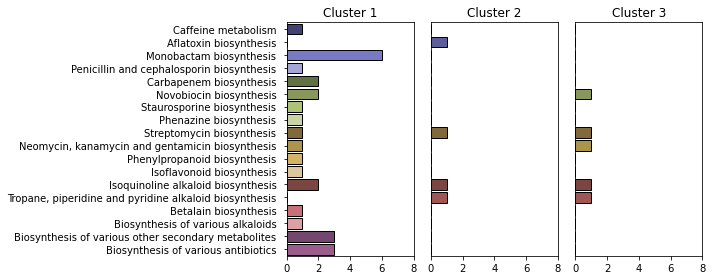

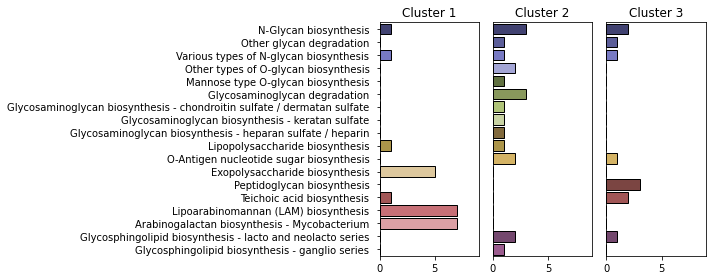

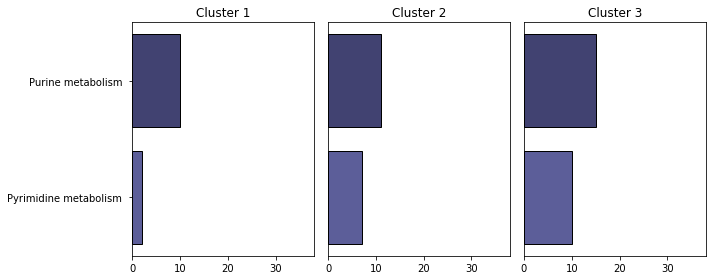

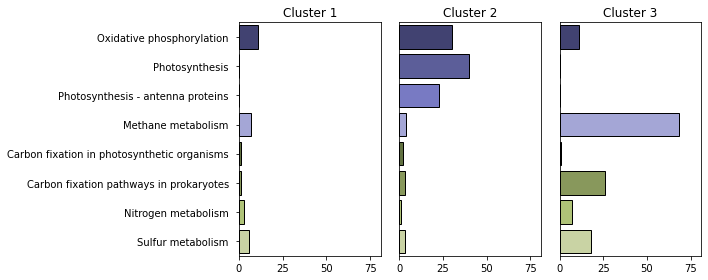

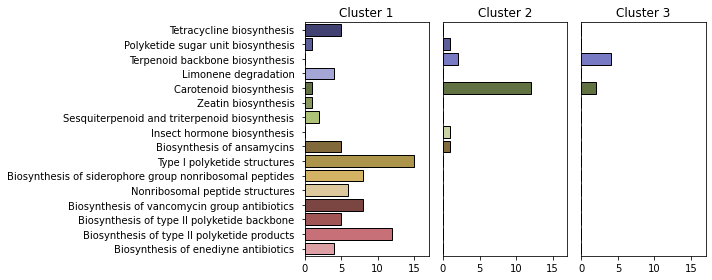

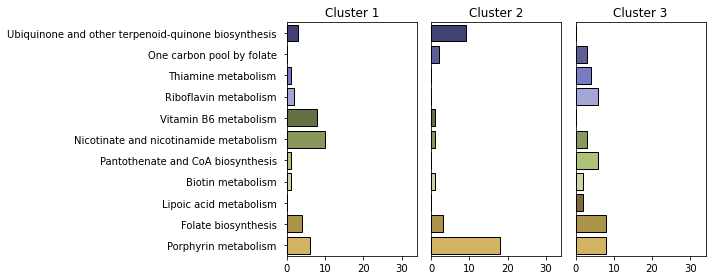

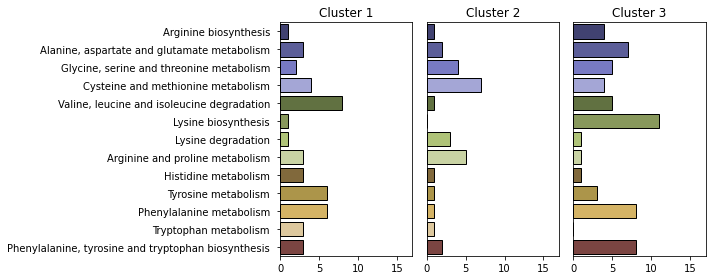

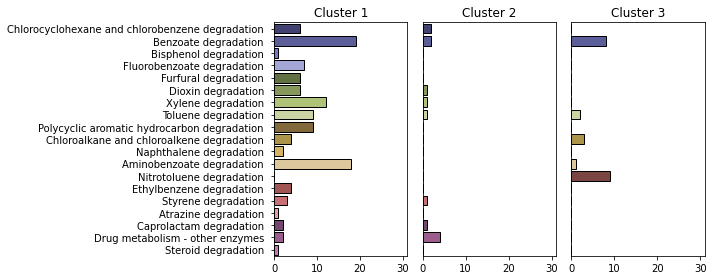

In [181]:
# Plot number of marker genes in the various subcategories of KEGG Metabolism
for j in set(combined[(combined[1]=='09100 Metabolism')][2]):
    fig, ax = plt.subplots(1, 3, figsize=(10,4))
    cats = np.sort(list(set(combined[(combined[2]==j)][3])))
    labels = [i.split('[')[0][6:] for i in cats]
    max_value = max(combined[combined[2]==j][3].value_counts())
    for i in [1,2,3]:
        tmp = combined[(combined[2]==j)&(combined.cluster=='Cluster_'+str(i))][3].value_counts()
        vals = [tmp[j] if j in tmp.index else 0. for j in cats]
        print(labels)
        print(vals)
        sns.barplot(y=labels, x=vals, ax=ax[i-1], palette='tab20b', edgecolor='black')
        ax[i-1].set_title('Cluster '+str(i))
        ax[i-1].set_ylabel('')
        ax[i-1].set_xlim([0,max_value+2])
        if i != 1:
            ax[i-1].set_yticks([])  
    plt.tight_layout()
    plt.savefig('figures/'+j+'_bar.png', dpi=300, facecolor='white')

[0.0, 5, 0.0, 2, 0.0, 11, 15, 20, 22, 2, 0.0, 3, 76, 0.0, 1, 34, 112, 12, 5, 1, 8, 0.0, 25, 1, 0.0, 0.0, 0.0, 0.0, 6, 5, 1, 1, 1, 0.0, 0.0, 4, 3, 0.0, 0.0, 0.0, 0.0, 1, 4, 0.0, 0.0, 0.0]
[71, 0.0, 1, 3, 1, 37, 44, 6, 8, 5, 4, 3, 0.0, 28, 2, 0.0, 67, 0.0, 2, 0.0, 4, 2, 10, 53, 34, 9, 16, 42, 24, 28, 25, 88, 57, 32, 27, 30, 50, 11, 3, 1, 37, 68, 61, 1, 45, 1]
[0.0, 0.0, 0.0, 0.0, 0.0, 8, 24, 12, 1, 1, 1, 5, 0.0, 1, 7, 8, 78, 13, 10, 0.0, 17, 47, 36, 21, 30, 16, 32, 9, 20, 3, 14, 2, 0.0, 1, 1, 9, 17, 0.0, 0.0, 1, 0.0, 2, 6, 0.0, 3, 0.0]


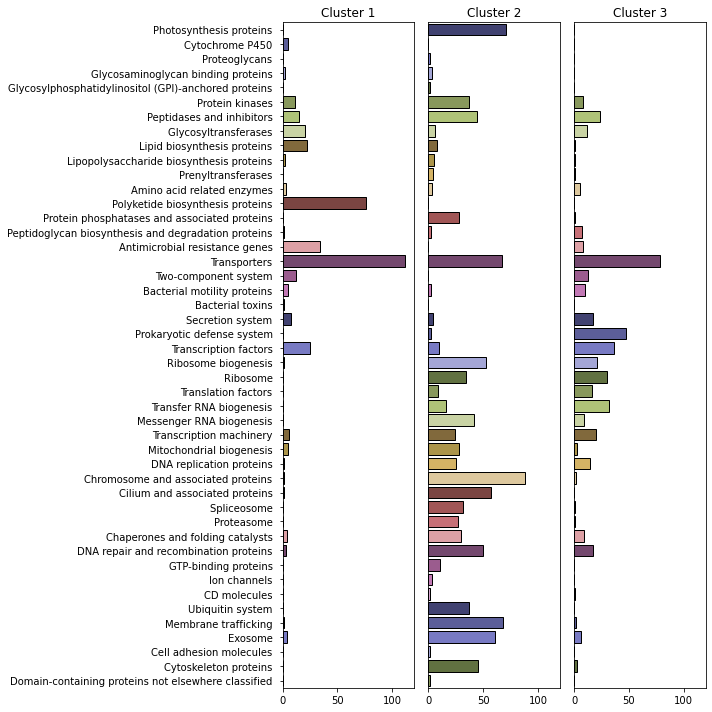

In [182]:
#Plot number of marker genes in KEGG Brite Hierarchy categories
fig, ax = plt.subplots(1, 3, figsize=(10,10))
cats = np.sort(list(set(combined[(combined[1]=='09180 Brite Hierarchies')][3])))
labels = [i.split('[')[0][6:] for i in cats]

for i in [1,2,3]:
    tmp = combined[(combined[1]=='09180 Brite Hierarchies')&(combined.cluster=='Cluster_'+str(i))][3].value_counts()
    vals = [tmp[j] if j in tmp.index else 0. for j in cats]
    print(vals)
    sns.barplot(y=labels, x=vals, ax=ax[i-1], palette='tab20b', edgecolor='black')
    ax[i-1].set_title('Cluster '+str(i))
    ax[i-1].set_ylabel('')
    ax[i-1].set_xlim([0,120])
    if i != 1:
        ax[i-1].set_yticks([])  
plt.tight_layout()
plt.savefig('figures/09180_Brite_Hierarchies_bar.png', dpi=300, facecolor='white')

In [651]:
#Output csv with marker genes labeled as transporters
combined[combined[3]=='02000 Transporters [BR:ko02000]'].to_csv('output/transporters.csv')

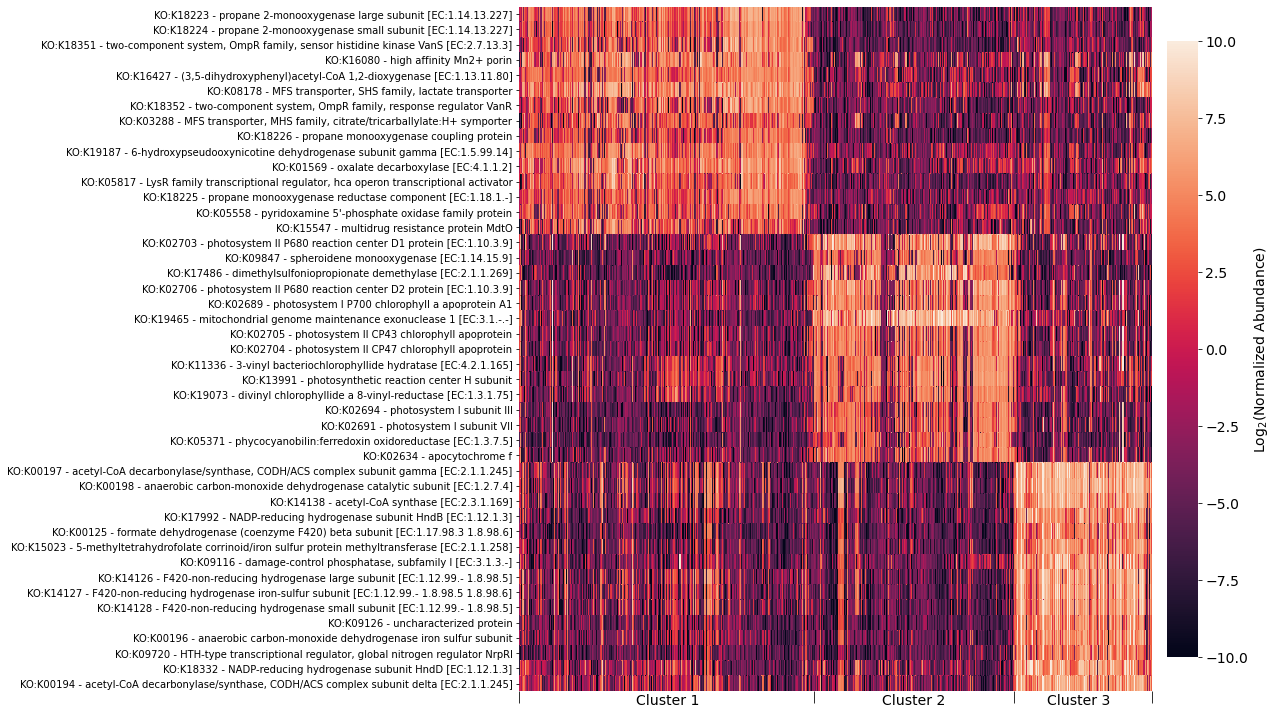

In [94]:
#Heatmap of top 15 marker genes
keys = list(adata.var.sort_values(by='minfc_1', ascending=False).head(15).index)
keys = np.append(keys, list(adata.var.sort_values(by='minfc_2', ascending=False).head(15).index))
keys = np.append(keys, list(adata.var.sort_values(by='minfc_3', ascending=False).head(15).index))

names = list(adata.var.sort_values(by='minfc_1', ascending=False).head(15).ko_name)
names = np.append(names, list(adata.var.sort_values(by='minfc_2', ascending=False).head(15).ko_name))
names = np.append(names, list(adata.var.sort_values(by='minfc_3', ascending=False).head(15).ko_name))

y_labels = [j+' - '+names[i] for i,j in enumerate(keys)]

num_1 = np.sum(adata.obs.kmeans=='Cluster 1')
num_2 = np.sum(adata.obs.kmeans=='Cluster 2')
num_3 = np.sum(adata.obs.kmeans=='Cluster 3')
ticks = [0, num_1-1, num_1+num_2-1, num_1+num_2+num_3-1] #minus one bc zero indexing

to_plot = np.append(np.append(adata[adata.obs.kmeans=='Cluster 1', keys].X, adata[adata.obs.kmeans=='Cluster 2', keys].X, axis=0)
                      , adata[adata.obs.kmeans=='Cluster 3', keys].X, axis=0).T
plt.figure(figsize=(18,10))
ax=sns.heatmap(to_plot, xticklabels=False, yticklabels=y_labels, cbar_kws={'label':'Log$_2$(Normalized Abundance)','shrink':0.9, 'pad':0.02}, vmin=-10, vmax=10)
plt.xticks(ticks, size=500)
plt.tick_params('x', length=12, bottom=True, top=False)
plt.text(1200, 45.9, 'Cluster 1', size=14)
plt.text(3750, 45.9, 'Cluster 2', size=14)
plt.text(5450, 45.9, 'Cluster 3', size=14)
ax.figure.axes[-1].yaxis.label.set_size(14)
ax.figure.axes[-1].tick_params(labelsize=14)

plt.tight_layout()
plt.savefig('figures/combined_heatmap.png', dpi=300)

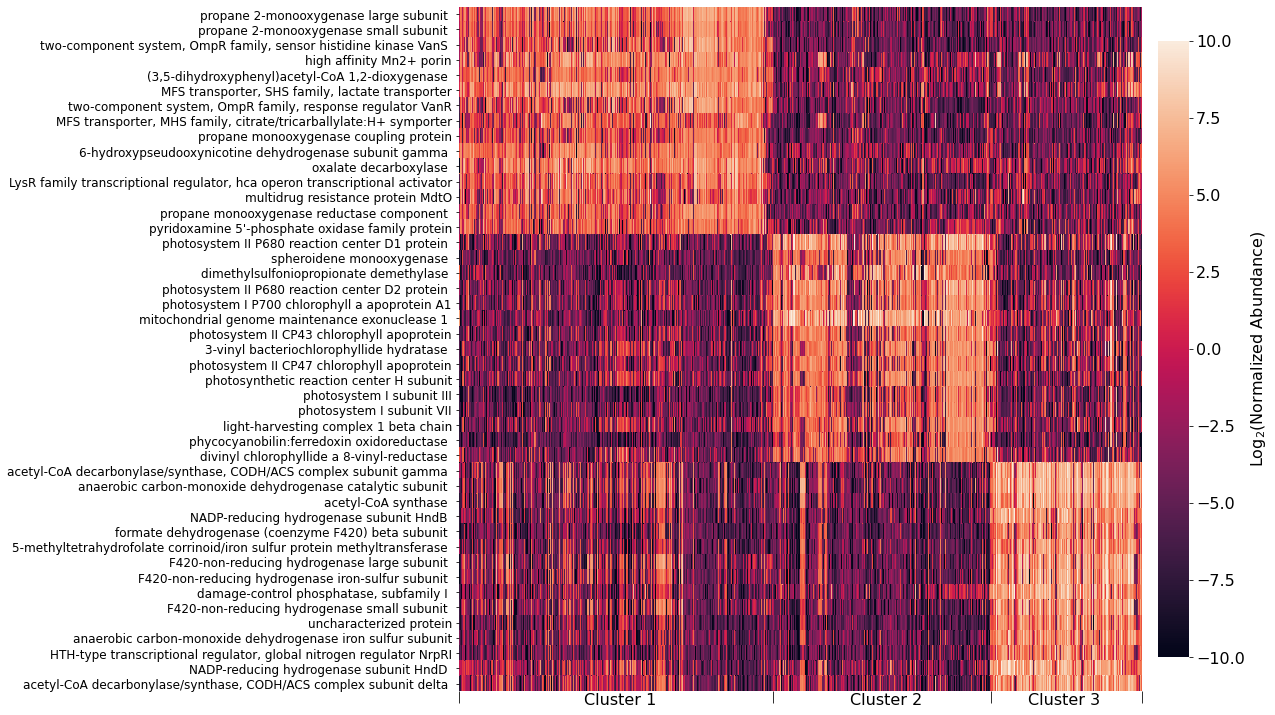

In [190]:
#Heatmap of top 15 marker genes with shorter gene names
keys = list(adata.var.sort_values(by='minfc_1', ascending=False).head(15).index)
keys = np.append(keys, list(adata.var.sort_values(by='minfc_2', ascending=False).head(15).index))
keys = np.append(keys, list(adata.var.sort_values(by='minfc_3', ascending=False).head(15).index))

names = list(adata.var.sort_values(by='minfc_1', ascending=False).head(15).ko_name)
names = np.append(names, list(adata.var.sort_values(by='minfc_2', ascending=False).head(15).ko_name))
names = np.append(names, list(adata.var.sort_values(by='minfc_3', ascending=False).head(15).ko_name))

y_labels = [names[i].split('[')[0] for i,j in enumerate(keys)]#make names shorter

num_1 = np.sum(adata.obs.kmeans=='Cluster 1')
num_2 = np.sum(adata.obs.kmeans=='Cluster 2')
num_3 = np.sum(adata.obs.kmeans=='Cluster 3')
ticks = [0, num_1-1, num_1+num_2-1, num_1+num_2+num_3-1] #minus one bc zero indexing

to_plot = np.append(np.append(adata[adata.obs.kmeans=='Cluster 1', keys].X, adata[adata.obs.kmeans=='Cluster 2', keys].X, axis=0)
                      , adata[adata.obs.kmeans=='Cluster 3', keys].X, axis=0).T
plt.figure(figsize=(18,10))
ax=sns.heatmap(to_plot, xticklabels=False, yticklabels=y_labels, cbar_kws={'label':'Log$_2$(Normalized Abundance)','shrink':0.9, 'pad':0.02}, vmin=-10, vmax=10)
plt.xticks(ticks, size=500)
plt.tick_params('x', length=12, bottom=True, top=False)
plt.text(1200, 45.9, 'Cluster 1', size=16)
plt.text(3750, 45.9, 'Cluster 2', size=16)
plt.text(5450, 45.9, 'Cluster 3', size=16)
ax.figure.axes[-1].yaxis.label.set_size(16)
ax.figure.axes[-1].tick_params(labelsize=16)
ax.figure.axes[0].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('figures/combined_heatmap_v3.png', dpi=300)

## GC content comparison and gene correlations

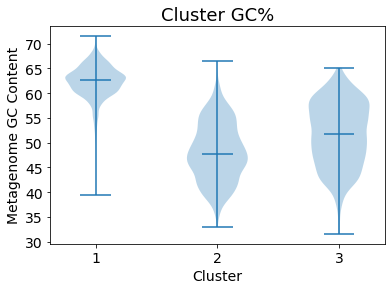

In [109]:
#Plot distribution of metagenomes GC contents in each cluster
plt.violinplot([adata.obs[adata.obs.kmeans=='Cluster 1']['GC   * assembled'], adata.obs[adata.obs.kmeans=='Cluster 2']['GC   * assembled'], adata.obs[adata.obs.kmeans=='Cluster 3']['GC   * assembled']],
               positions=[1,2,3], showmedians=True)
plt.ylabel('Metagenome GC Content', size=14)
plt.xlabel('Cluster', size=14)
plt.xticks([1,2,3],fontsize=14)
plt.yticks(fontsize=14)
plt.title('Cluster GC%', size=18)
plt.savefig('figures/Cluster_gc_violin.png', dpi=300)

In [110]:
#test for statistical differences between gc content
kruskal(adata.obs[adata.obs.kmeans=='Cluster 1']['GC   * assembled'], adata.obs[adata.obs.kmeans=='Cluster 2']['GC   * assembled'], adata.obs[adata.obs.kmeans=='Cluster 3']['GC   * assembled'])

KruskalResult(statistic=4329.633166503653, pvalue=0.0)

In [111]:
#Post-hoc test
scikit_posthocs.posthoc_dunn([adata.obs[adata.obs.kmeans=='Cluster 1']['GC   * assembled'], adata.obs[adata.obs.kmeans=='Cluster 2']['GC   * assembled'], adata.obs[adata.obs.kmeans=='Cluster 3']['GC   * assembled']])

,1,2,3
1,1.0,0.000000e+00,0.000000e+00
2,0.0,1.000000e+00,6.733694e-26
3,0.0,6.733694e-26,1.000000e+00


In [112]:
#Perform linear regression between metagenome GC content and gene abundance
from scipy.stats import linregress

rvals = []
pvals = []
for gene in adata.var.index:
    rval = linregress(adata.obs['GC   * assembled'], np.transpose(adata.X[:, adata.var.index == gene])).rvalue
    pval = linregress(adata.obs['GC   * assembled'], np.transpose(adata.X[:, adata.var.index == gene])).pvalue
    rvals.append(rval)
    pvals.append(pval)
    
rval_df = adata.var.copy()
rval_df['r'] = rvals
rval_df['p'] = pvals
rval_df.sort_values(by='r', ascending=False).head(50)

,ko_name,n_cells,kruskal_pval,dunns_1-2,dunns_1-3,dunns_2-3,fc_1-2,fc_1-3,fc_2-3,minfc_1,minfc_2,minfc_3,maxp_1,maxp_2,maxp_3,r,p
ko_id,,,,,,,,,,,,,,,,,
KO:K06044,(1->4)-alpha-D-glucan 1-alpha-D-glucosylmutase...,5669,0.0,0.0,1.693871e-234,1.801983e-104,7.492672,2.539268,-4.953404,2.539268,-7.492672,-2.539268,1.693871e-234,1.801983e-104,1.801983e-104,0.766786,0.0
KO:K01971,bifunctional non-homologous end joining protei...,6279,0.0,0.0,8.645566e-237,6.133938e-127,6.348872,2.688813,-3.660059,2.688813,-6.348872,-2.688813,8.645566e-237,6.133938e-127,6.133938e-127,0.764521,0.0
KO:K00697,trehalose 6-phosphate synthase [EC:2.4.1.15 2....,6335,0.0,0.0,3.170679e-173,6.253080e-149,4.478254,1.606459,-2.871795,1.606459,-4.478254,-1.606459,3.170679e-173,6.253080e-149,6.253080e-149,0.763392,0.0
KO:K10979,DNA end-binding protein Ku,6059,0.0,0.0,7.456317e-277,9.772234e-89,6.685275,3.362756,-3.322519,3.362756,-6.685275,-3.362756,7.456317e-277,9.772234e-89,9.772234e-89,0.761356,0.0
KO:K01236,maltooligosyltrehalose trehalohydrolase [EC:3....,5678,0.0,0.0,8.668160e-238,2.971462e-91,7.205588,2.653357,-4.552232,2.653357,-7.205588,-2.653357,8.668160e-238,2.971462e-91,2.971462e-91,0.759793,0.0
KO:K06324,"spore coat protein A, manganese oxidase [EC:1....",4958,0.0,0.0,3.507074e-213,3.643438e-70,7.566729,3.521299,-4.045430,3.521299,-7.566729,-3.521299,3.507074e-213,3.643438e-70,3.643438e-70,0.736322,0.0
KO:K08995,putative membrane protein,5208,0.0,0.0,0.000000e+00,2.767278e-02,6.170801,5.502579,-0.668222,5.502579,-6.170801,-5.502579,0.000000e+00,2.767278e-02,2.767278e-02,0.726433,0.0
KO:K05343,maltose alpha-D-glucosyltransferase / alpha-am...,6410,0.0,0.0,4.233765e-190,1.209471e-134,4.309208,1.858263,-2.450945,1.858263,-4.309208,-1.858263,4.233765e-190,1.209471e-134,1.209471e-134,0.722691,0.0
KO:K18223,propane 2-monooxygenase large subunit [EC:1.14...,3594,0.0,0.0,0.000000e+00,3.744534e-05,9.210962,8.667866,-0.543096,8.667866,-9.210962,-8.667866,0.000000e+00,3.744534e-05,3.744534e-05,0.721191,0.0


In [113]:
#Output top 50 genes most correlated with low GC content
rval_df.sort_values(by='r', ascending=True).head(50).to_csv('output/low_gc_genes.csv')

In [114]:
#Output top 50 genes most correlated with high GC content
rval_df.sort_values(by='r', ascending=False).head(50).to_csv('output/high_gc_genes.csv')

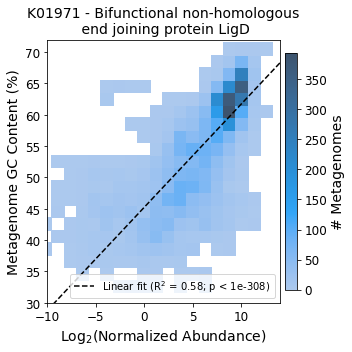

In [117]:
# Plot GC vs LigD
plt.figure(figsize=(5,5))
ax=sns.histplot(x=adata.X[:, adata.var.index=='KO:K01971'][:,0], y=adata.obs['GC   * assembled'], bins=20, cbar=True, cbar_kws={'label':'# Metagenomes','shrink':0.9, 'pad':0.02})
m, b = np.polyfit(adata.X[:, adata.var.index=='KO:K01971'][:,0], adata.obs['GC   * assembled'], 1)
plt.plot(np.arange(-10,16,0.2), m*np.arange(-10,16,0.2)+b, color='black', linestyle='--', label='Linear fit (R$^2$ = 0.58; p < 1e-308)')
plt.ylabel('Metagenome GC Content (%)', size=14)
plt.xlabel('Log$_2$(Normalized Abundance)', size=14)
plt.title('K01971 - Bifunctional non-homologous\n end joining protein LigD', size=14)
plt.xlim([-10, 14])
plt.ylim([30, 72])
plt.tick_params(labelsize=12)
plt.legend(loc='lower right')
ax.figure.axes[-1].yaxis.label.set_size(14)
ax.figure.axes[-1].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('figures/GC_vs_LigD_histplot.png', facecolor='white', dpi=300)

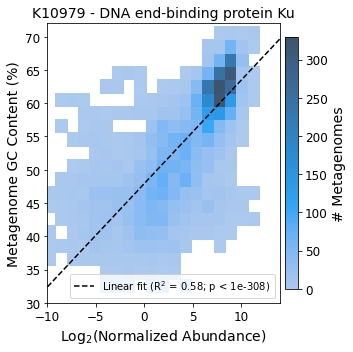

In [118]:
# Plot GC vs Ku
plt.figure(figsize=(5,5))
ax=sns.histplot(x=adata.X[:, adata.var.index=='KO:K10979'][:,0], y=adata.obs['GC   * assembled'], bins=20, cbar=True, cbar_kws={'label':'# Metagenomes','shrink':0.9, 'pad':0.02})
m, b = np.polyfit(adata.X[:, adata.var.index=='KO:K10979'][:,0], adata.obs['GC   * assembled'], 1)
plt.plot(np.arange(-10,16,0.2), m*np.arange(-10,16,0.2)+b, color='black', linestyle='--', label='Linear fit (R$^2$ = 0.58; p < 1e-308)')
plt.ylabel('Metagenome GC Content (%)', size=14)
plt.xlabel('Log$_2$(Normalized Abundance)', size=14)
plt.title('K10979 - DNA end-binding protein Ku', size=14)
plt.xlim([-10, 14])
plt.ylim([30, 72])
plt.tick_params(labelsize=12)
plt.legend(loc='lower right')
ax.figure.axes[-1].yaxis.label.set_size(14)
ax.figure.axes[-1].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('figures/GC_vs_Ku_histplot.png', facecolor='white', dpi=300)

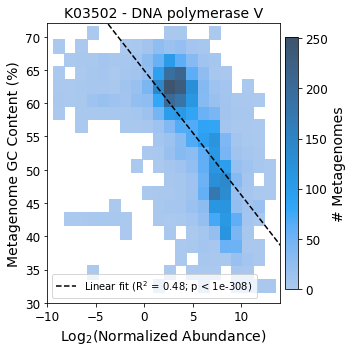

In [119]:
# Plot GC vs polV
plt.figure(figsize=(5,5))
ax=sns.histplot(x=adata.X[:, adata.var.index=='KO:K03502'][:,0], y=adata.obs['GC   * assembled'], bins=20, cbar=True, cbar_kws={'label':'# Metagenomes','shrink':0.9, 'pad':0.02})
m, b = np.polyfit(adata.X[:, adata.var.index=='KO:K03502'][:,0], adata.obs['GC   * assembled'], 1)
plt.plot(np.arange(-10,16,0.2), m*np.arange(-10,16,0.2)+b, color='black', linestyle='--', label='Linear fit (R$^2$ = 0.48; p < 1e-308)')
plt.ylabel('Metagenome GC Content (%)', size=14)
plt.xlabel('Log$_2$(Normalized Abundance)', size=14)
plt.title('K03502 - DNA polymerase V', size=14)
plt.xlim([-10, 14])
plt.ylim([30, 72])
plt.tick_params(labelsize=12)
plt.legend(loc='lower left')
ax.figure.axes[-1].yaxis.label.set_size(14)
ax.figure.axes[-1].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('figures/GC_vs_polV_histplot.png', facecolor='white', dpi=300)

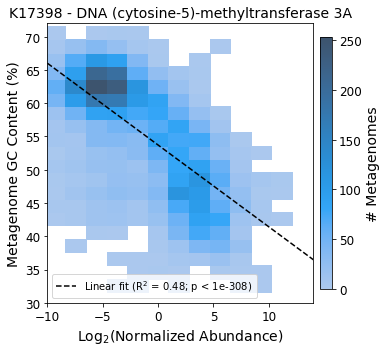

In [120]:
# Plot GC vs cytosine methyltransferase
plt.figure(figsize=(5.5,5))
ax=sns.histplot(x=adata.X[:, adata.var.index=='KO:K17398'][:,0], y=adata.obs['GC   * assembled'], bins=20, cbar=True, cbar_kws={'label':'# Metagenomes','shrink':0.9, 'pad':0.02})
m, b = np.polyfit(adata.X[:, adata.var.index=='KO:K17398'][:,0], adata.obs['GC   * assembled'], 1)
plt.plot(np.arange(-10,16,0.2), m*np.arange(-10,16,0.2)+b, color='black', linestyle='--', label='Linear fit (R$^2$ = 0.48; p < 1e-308)')
plt.ylabel('Metagenome GC Content (%)', size=14)
plt.xlabel('Log$_2$(Normalized Abundance)', size=14)
plt.title('K17398 - DNA (cytosine-5)-methyltransferase 3A', size=14)
plt.xlim([-10, 14])
plt.ylim([30, 72])
plt.tick_params(labelsize=12)
plt.legend(loc='lower left')
ax.figure.axes[-1].yaxis.label.set_size(14)
ax.figure.axes[-1].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('figures/GC_vs_methyltransferase_histplot.png', facecolor='white', dpi=300)